# Hypothesis testing for the difference between two binomials distributions

Hypothesis testing for a [binomial proportion](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) is a well-studied problem. Most statistical libraries contain [multiple methods](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html) of generating confidence intervals (CIs) for a binomial proportion. Testing the *difference* between two binomial proportions is a similar statistical problem, although the range of available methods is more limited. In my experience, most statistical handbooks recommend using normal approximations or contingency tables when there are two sets of binary outcomes. Unfortunately these approaches have drawbacks. Normal approximations based on asymptotic theory which lead to erroneous coverage when sample sizes are small or the probability of an event is close to zero or one. Though Fisher's Exact test is able to obtain the right nominal levels, it is harder to perform calculations for and has difficulty scaling to larger outcome spaces. The idea of defining an *exact* distribution of the difference in two binomial proportions is not a new one (see [here](https://www.jstor.org/stable/2533740?seq=1) or [here](https://arxiv.org/pdf/1903.03327.pdf)). However these methods are not easily implementable and, as far as I know, not supported in languages like `python`. 

In this post I want to provide researchers with the tools to calculate p-values for differences in binomial distributions. I will also highlight the main challenge when carrying out hypothesis testing: whether the null proportion is known before the sampling. By the end of the post, I will provide:  

1. Functions to calculate the PMF and CDF for the distribution of a difference between binomials
2. Functions to generate CIs for this distribution at any nominal level
3. A novel proof that the empirical CIs are unknowably conservative when the null proportion needs to be estimated.

If the null value is null before testing, then the type-I errors will be conservative, but *knowably* so, since the difference between the targeted and actual levels will be determined by the discrete nature of the CDF. However, when the null proportion itself needs to be estimated, I will show that CIs will be more conservative than the CDF derived from the empirical null proportion. 

## (1) Review: Exact CIs for a single binomial distribution

This first section will review the binomial distribution, establish notation, and show has exact and knowably-conservative CIs can be constructed for hypothesis testing. The binomial distribution, $y \sim B(n,\pi)$, is parameterized by the number of trials ($n$) and the probability of a positive outcome ($\pi$), where $E(y)=\pi$. As there are many ways to have $k$ successes, the PMF of this discrete distribution uses the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient) to capture these *combinations*:

$$
\begin{align*}
f_{\pi,n}(k) &= P(y = k) = \begin{pmatrix} n \\ k \end{pmatrix} \pi^k (1-\pi)^{1-k} \\
F_{\pi,n}(k) &= P(y \leq k) = \sum_{j=0}^k f_{\pi,n}(j)
\end{align*}
$$

The binomial distribution can represent a number of useful processes we may want to carry out inference on such as the frequency of credit defaults, the sensitivity of a test, or the precision of a classier. All of these processes  count the number of times a binary event happens out of a total number of trials. Hypothesis testing for a binomial random variable is therefore to reject (or not) some claim about the underlying proportion $\pi$. For example if we wanted to test whether a medical test had a sensitivity of greater than 90% we would want to reject the following null:

$$
\begin{align*}
H_0:& \pi \leq 0.9 \\
H_A:& \pi > 0.9
\end{align*}
$$

The confidence intervals for a binomial proportion amount to constructing an interval $(l,u)$, such that:

$$
\begin{align*}
P(\pi \in [l, u]| H_0) \geq 1-\alpha \hspace{1mm} 
\end{align*}
$$

The upper- and lower-bounds will best on the test statistic: $\hat\pi=y/n$, so that $l=\hat\pi-(k_{1-\alpha/2}^*-\pi_0)$ and $u=\hat\pi+(\pi_0-k_{\alpha/2}^*)$. 

In [3]:
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
from scipy import stats

In [6]:
np.random.binomial(1000,0.9,100)

array([916, 907, 896, 902, 886, 900, 891, 898, 907, 905, 916, 907, 893,
       894, 897, 893, 897, 886, 902, 895, 909, 873, 891, 901, 893, 913,
       914, 898, 885, 902, 897, 896, 897, 900, 912, 903, 903, 903, 902,
       904, 912, 896, 903, 903, 910, 890, 906, 904, 913, 890, 894, 902,
       876, 908, 892, 902, 914, 893, 896, 901, 893, 900, 897, 894, 917,
       889, 912, 896, 925, 918, 888, 887, 893, 898, 897, 899, 895, 901,
       898, 898, 908, 897, 902, 899, 906, 897, 912, 904, 907, 915, 903,
       879, 905, 899, 900, 888, 895, 906, 909, 891])



Or one might want to test whether the proportion of college admissions differs between men and women (with one of the sexes defined as a "success").


$p_i = y_i / n$ and $y_i \sim \text{Binom}(n,\pi_i)$ comes from a binomial distribution then the CIs do not need to be based on *approximations* because they can be calculated using the exact quantiles. However this approach is used less often than would normally be expected for two reasons. First, because the binomial distribution is discrete, the CDF may have large jumps. For example, consider the distribution of 20 fair coin flips where the probability that 14/15 or more heads will occur is 5.8%/2.1%, respectively. Second, the distribution between differences in binomials is a non-standard distribution. Clearly no threshold could be chosen which ensured *exactly* a 5% type-I error rate. Instead we would need to be conservative and pick 15 or more heads as the threshold associated with the 95% level -- which would yield a 2.1% type-I error rate for rejecting the null of $P(H\leq0.5)$. Hence the coverage region associated with the $1-\alpha$ level can obtained by conservatively inverting the CDF as \eqref{eq:thresh_binom} shows below.

$$
\begin{align}
P(K \leq k; n, \pi) &= F(k; n, \pi) = \begin{pmatrix} n \\ k \end{pmatrix} \pi^k (1-\pi)^{1-k} \nonumber \\ 
F^{-1}(\alpha; n, \pi) &= c_{\alpha}^* = \begin{cases} \inf_k \hspace{2mm} \{ k: F(k) \geq \alpha \} &\text{if}& \alpha \geq 0.5  \\ \sup_k \{ k: F(k) \leq \alpha \} &\text{if}& \alpha < 0.5  \end{cases} \label{eq:thresh_binom}
\end{align}
$$

For example since $F(13,20,0.5)\approx 0.94$ and $F(14,20,0.5)\approx 0.98$, then $c_{0.95}^{*}=14$. The simulations below shows that the rejection region generated from $t_\alpha^{*}$ leads to coverage that is *at least* 95% for the 95% level.


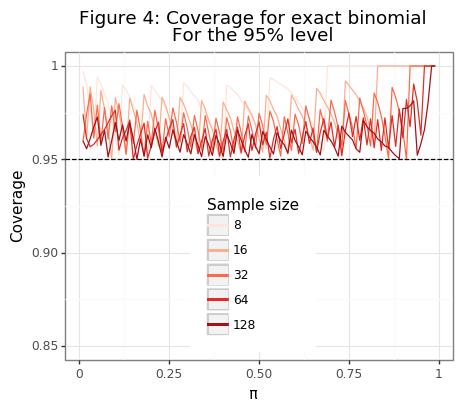

<ggplot: (-9223363275708652053)>

In [4]:
# Function to calculate t*_alpha
def qbinom(alpha, n, pi):
    assert (alpha >= 0) & (alpha <= 1)
    kstar = int(stats.binom.ppf(q=alpha,n=n,p=pi)) # Use first quantile estimate
    Fk = stats.binom.cdf(k=kstar,n=n,p=pi) # Calculate p-value
    check = bool(np.where(alpha>0.5, Fk>=alpha, Fk<=alpha))
    while not check:
        kstar = int(np.where(alpha>0.5, kstar+1, kstar-1))
        Fk = stats.binom.cdf(k=kstar,n=n,p=pi)
        check = bool(np.where(alpha>0.5, Fk>=alpha, Fk<=alpha))
    return kstar

nsim = 100000
alpha = 0.05
pi_seq = np.round(np.arange(0.01,1,0.01),2)
n_seq = 2**np.arange(3,8,1)

holder = []
for pi in pi_seq:
    for n in n_seq:
        # Establish the lower bound
        kstar = qbinom(alpha=1-alpha, n=n, pi=pi)
        # Draw data under the null
        khat = np.random.binomial(n, pi, size=nsim)
        phat = khat / n
        phat_ub = kstar / n
        coverage = np.mean(phat <= phat_ub)
        tmp = pd.DataFrame({'pi':pi,'n':n,'coverage':coverage},index=[0])
        holder.append(tmp)
sim_exact = pd.concat(holder).reset_index(None,True).assign(n=lambda x: pd.Categorical(x.n, x.n.unique()))

plotnine.options.figure_size = (5, 4)
gg_cov_exact = (ggplot(sim_exact, aes(x='pi',y='coverage',color='n'))+
               theme_bw() + geom_line() + 
               labs(x='π',y='Coverage') + 
               ggtitle('Figure 4: Coverage for exact binomial\nFor the 95% level') + 
               theme(legend_position=(0.5,0.35)) + 
               scale_y_continuous(limits=[0.85,1.0],breaks=list(np.arange(0.85,1.01,0.05))) + 
               geom_hline(yintercept=0.95,linetype='--') + 
               scale_color_brewer(name='Sample size', palette='Reds'))
gg_cov_exact

Figure 1 demonstrates how we can obtain a conservative coverage region for the binomial distribution. Keep in mind that in the case where $\pi$ is close to 0 or 1, and $n$ is small, the coverage region may amount to 100% for the 95% level! Though we have not yet even discussed power calculations for these exact CIs, it is clear that no sample size will be sufficient to reject the null in this case. For example if $n=8$ and $\pi=0.7$, then $F(7)=0.94$ and $F(8)=1.0$, so the coverage region amounts to $\hat p \leq 1$! In summary, though "exact" confidence intervals will not be able to obtain exact coverage due to their discrete nature. The second issue with using exact CIs for two proportions from a binomial distribution is that we need to develop a custom CDF and its quantile for $\delta=y_1 - y_2$. 

$$
\begin{align*}
s(d;\mathbf{n}, \mathbf{\pi}) &= \{ f_{Y_1}(k_1;n_1,\pi_1) \cdot f_{Y_2}(k_2;n_2,\pi_2) \hspace{1mm} | \hspace{1mm} k_1-k_2=d \} \\
f_\delta(d; \mathbf{n}, \mathbf{\pi}) &= \sum_{ s_i \in s(d)} s_i \\
F_\delta(d; \mathbf{n}, \mathbf{\pi}) &= P(K_1 - K_2 \leq d) \\
&= \sum_{j=-n_2}^d f_\delta(j; \mathbf{n}, \mathbf{\pi})
\end{align*}
$$

Computationally its easiest to calculate the PMF/CDF as a matrix and then group by all the values from $[-n_2,\dots,n_1]$ as the function `binom_diff` class shows below.

In [ ]:
class binom_diff():
    def __init__(self, n1, pi1, n2, pi2):
        check1 = (n1 >= 0) & (n2 >= 0) & (isinstance(n1,int)) & (isinstance(n1,int))
        check2 = (pi1 >= 0) & (pi1 <= 0) & (pi2 >= 0) & (pi2 <= 0)
        y1seq, y2seq = np.meshgrid(range(n1+1), range(n2+1)) # create the actual grid
        y1seq, y2seq = y1seq.flatten(), y2seq.flatten()
        s_d = stats.binom.pmf(y1seq, n1, pi1) * stats.binom.pmf(y2seq, n2, pi2)
        self.df = pd.DataFrame({'d':y1seq-y2seq,'pdf':s_d}).groupby('d').pdf.sum().reset_index()
        assert np.abs(self.df.pdf.sum() - 1) < 1e-6
        self.df['cdf'] = self.df.pdf.cumsum()
    def cdf(self, d):
        return self.df.query('d == @d').cdf.values[0]
    def qdf(self, p):
        assert (p >= 0) & (p <= 1)
        if p > 0.5:
            dstar = dist.df.query('cdf >= @p').head(1).d.values[0]
        elif p < 0.5:
            dstar = self.df.query('cdf <= @p').tail(1).d.values[0]
        else:
            dstar = int(self.df.loc[np.argmin((self.df.cdf-0.5)**2)]['d'])
        return dstar
    
# Check that the QQ-plots line up
np.random.seed(seed)
nsim = 10000000
n1, n2 = 100, 150
pi1, pi2 = 0.5, 0.5
res = pd.Series(np.random.binomial(n1,pi1,nsim) - np.random.binomial(n2,pi2,nsim)).value_counts(True).reset_index()
res = res.rename(columns={'index':'n',0:'p'}).sort_values('n').reset_index(None,True)
dist_dbinom = binom_diff(n1, pi1, n2, pi2)
df_comp = res.assign(ecdf=lambda x: x.p.cumsum()).drop(columns='p')
df_comp = df_comp.merge(dist_dbinom.df,'left',left_on='n',right_on='d').drop(columns='pdf')
df_comp = df_comp.melt('d',['cdf','ecdf'],'tt')

title5 = 'Figure 5: Empirical vs Theoretical CDF\nn1=100, n2=150, pi1=pi2=0.5'
plotnine.options.figure_size = (5.5, 4)
gg_cdf_check = (ggplot(df_comp, aes(x='d',y='value',color='tt')) + theme_bw() + 
                geom_point() + labs(y='CDF',x='d') + ggtitle(title5) + 
                scale_color_discrete(name='CDF',labels=['Theory','Empirical']))
gg_cdf_check